In [1]:
from datetime import datetime
import dask.delayed
import xarray as xr
import numpy as np
import os
#import matplotlib as mpl
#import matplotlib.pyplot as plt
from global_land_mask import globe
import dask
import dask.array as da


def haversine_distance_dask(lat, lon):
    """
    Calculate pairwise distances between points using Haversine formula.

    Parameters:
    - lat (ndarray) : 1-d flattened latitude grid
    - lon (ndarray) : 1-d flattened longitude grid
    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat_rad = da.radians(lat)
    lon_rad = da.radians(lon)

    # Compute differences in latitude and longitude
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad

    # Haversine formula
    a = da.sin(dlat / 2.0) ** 2 + da.cos(lat_rad) * da.cos(lat_rad[:, np.newaxis]) * da.sin(dlon / 2.0) ** 2
    c = 2 * da.arctan2(da.sqrt(a), da.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances


def create_lsm(latmin, latmax, lonmin, lonmax):
     """Creates a land-sea mask (land=1, sea=0) in 0.1 deg x 0.1 deg resolution
     for the chosen area.
     """
     lat = np.linspace(latmin,latmax, (latmax-latmin)*10+1) #, dtype=np.float32)
     lon = np.linspace(lonmin,lonmax, (lonmax - lonmin)*10+1) #, dtype=np.float32)
     longrid, latgrid = np.meshgrid(lon,lat)
     lsm = globe.is_land(latgrid, longrid)
   
     return lsm, latgrid, longrid

def compute_cov_dask(lsm, latgrid, longrid, sigmas, L, v):
    if v == "land":
        latv = latgrid[lsm].flatten()
        lonv = longrid[lsm].flatten()
        
             
            
    elif v == "ocean":
        latv = latgrid[~lsm].flatten()
        lonv = longrid[~lsm].flatten()     

    latv = da.from_array(latv)
    lonv = da.from_array(lonv)
    covv = da.empty((len(latv), len(latv)))       
    sigma = sigmas[v]
    l = L[v]
    covv[:,:] = sigma**2*da.exp(-1*haversine_distance_dask(latv, lonv)/l)

    return covv, latv, lonv
        
             

 
def create_dataset(covv, latv, lonv, v):
    
    """
    Creates an xarray dataset of the covariance matrix and coordinates of the grid.
    """
    out_cov = xr.Dataset(
    data_vars={"covariance": (["dim0", "dim1"], covv),
               "lon": (lonv),
                "lat": (latv),},
    attrs={'comment': f"Prior covariance matrix of CO2 {v} fluxes"})
    return out_cov
    




SystemError: initialization of _internal failed without raising an exception

In [2]:
from dask.distributed import Client
client = Client(n_workers = 4)
client

2024-05-24 13:12:14,695 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8ndsb6ul', purging
2024-05-24 13:12:14,696 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wdlmw1ro', purging
2024-05-24 13:12:14,696 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-r4vm_jpg', purging
2024-05-24 13:12:14,696 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7g5k6n5r', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37669,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.78 GiB
Comm: tcp://127.0.0.1:36735,Total threads: 2
Dashboard: http://127.0.0.1:32851/status,Memory: 7.69 GiB
Nanny: tcp://127.0.0.1:42983,


In [22]:
#Europe
# latmin = 30
# latmax = 75
# lonmin = -15
# lonmax = 40

#smaller testarea
latmin = 30
latmax = 50
lonmin = -10
lonmax = 0

# Uncertainty (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean

v = "land"

In [40]:
lsm, latgrid, longrid = create_lsm(latmin, latmax, lonmin, lonmax)
covv, latv, lonv = compute_cov_dask(lsm, latgrid, longrid, sigmas, L, v)
out_covv = create_dataset(covv, latv, lonv, v)


In [41]:
today = datetime.now()
output_filename = f'CO2_prior_cov_test_{v}_{today.strftime("%d%m%Y")}.nc'
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
w = out_covv.to_netcdf(os.path.join(OUTPUT_PATH, output_filename), compute = False)

In [42]:
w.compute()

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

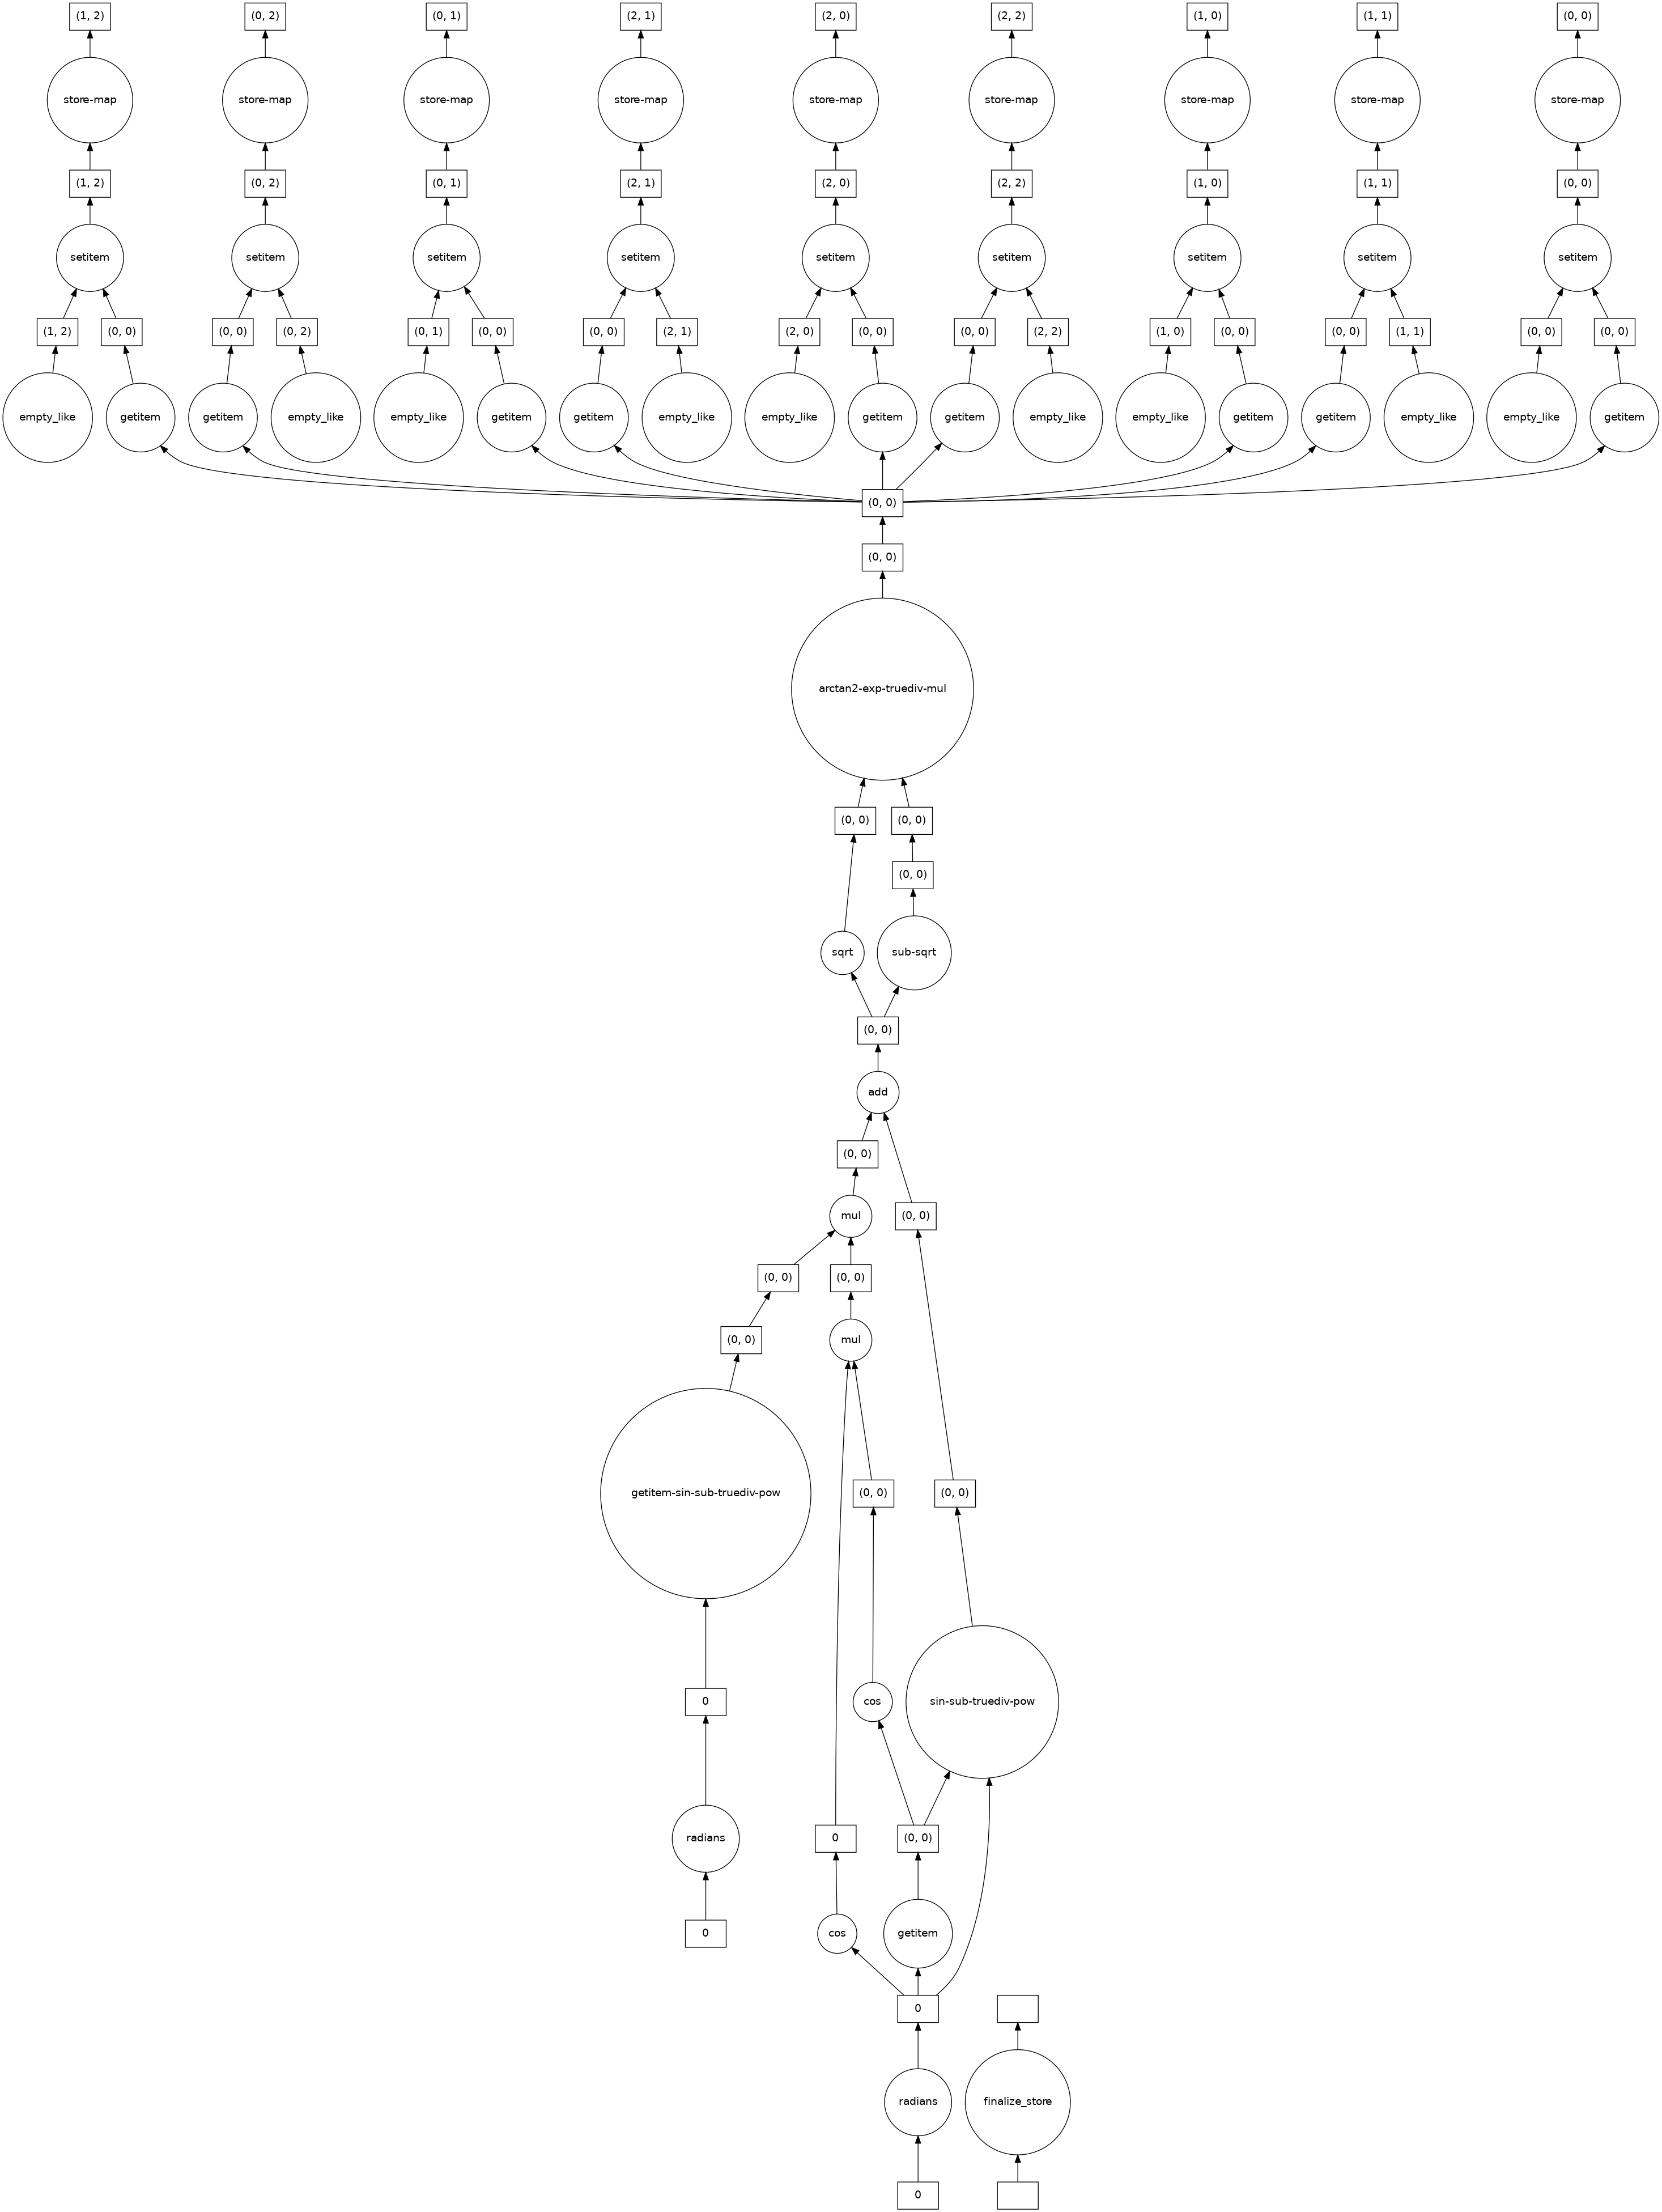

In [37]:
w.visualize()

In [31]:
covv.dask

HighLevelGraph with 2 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f71c0a55a80>
 0. empty_like-51d52655aed79b76370f3fdb41636d1f
 1. setitem-f27964146cb3d4127e8a8d341408194b

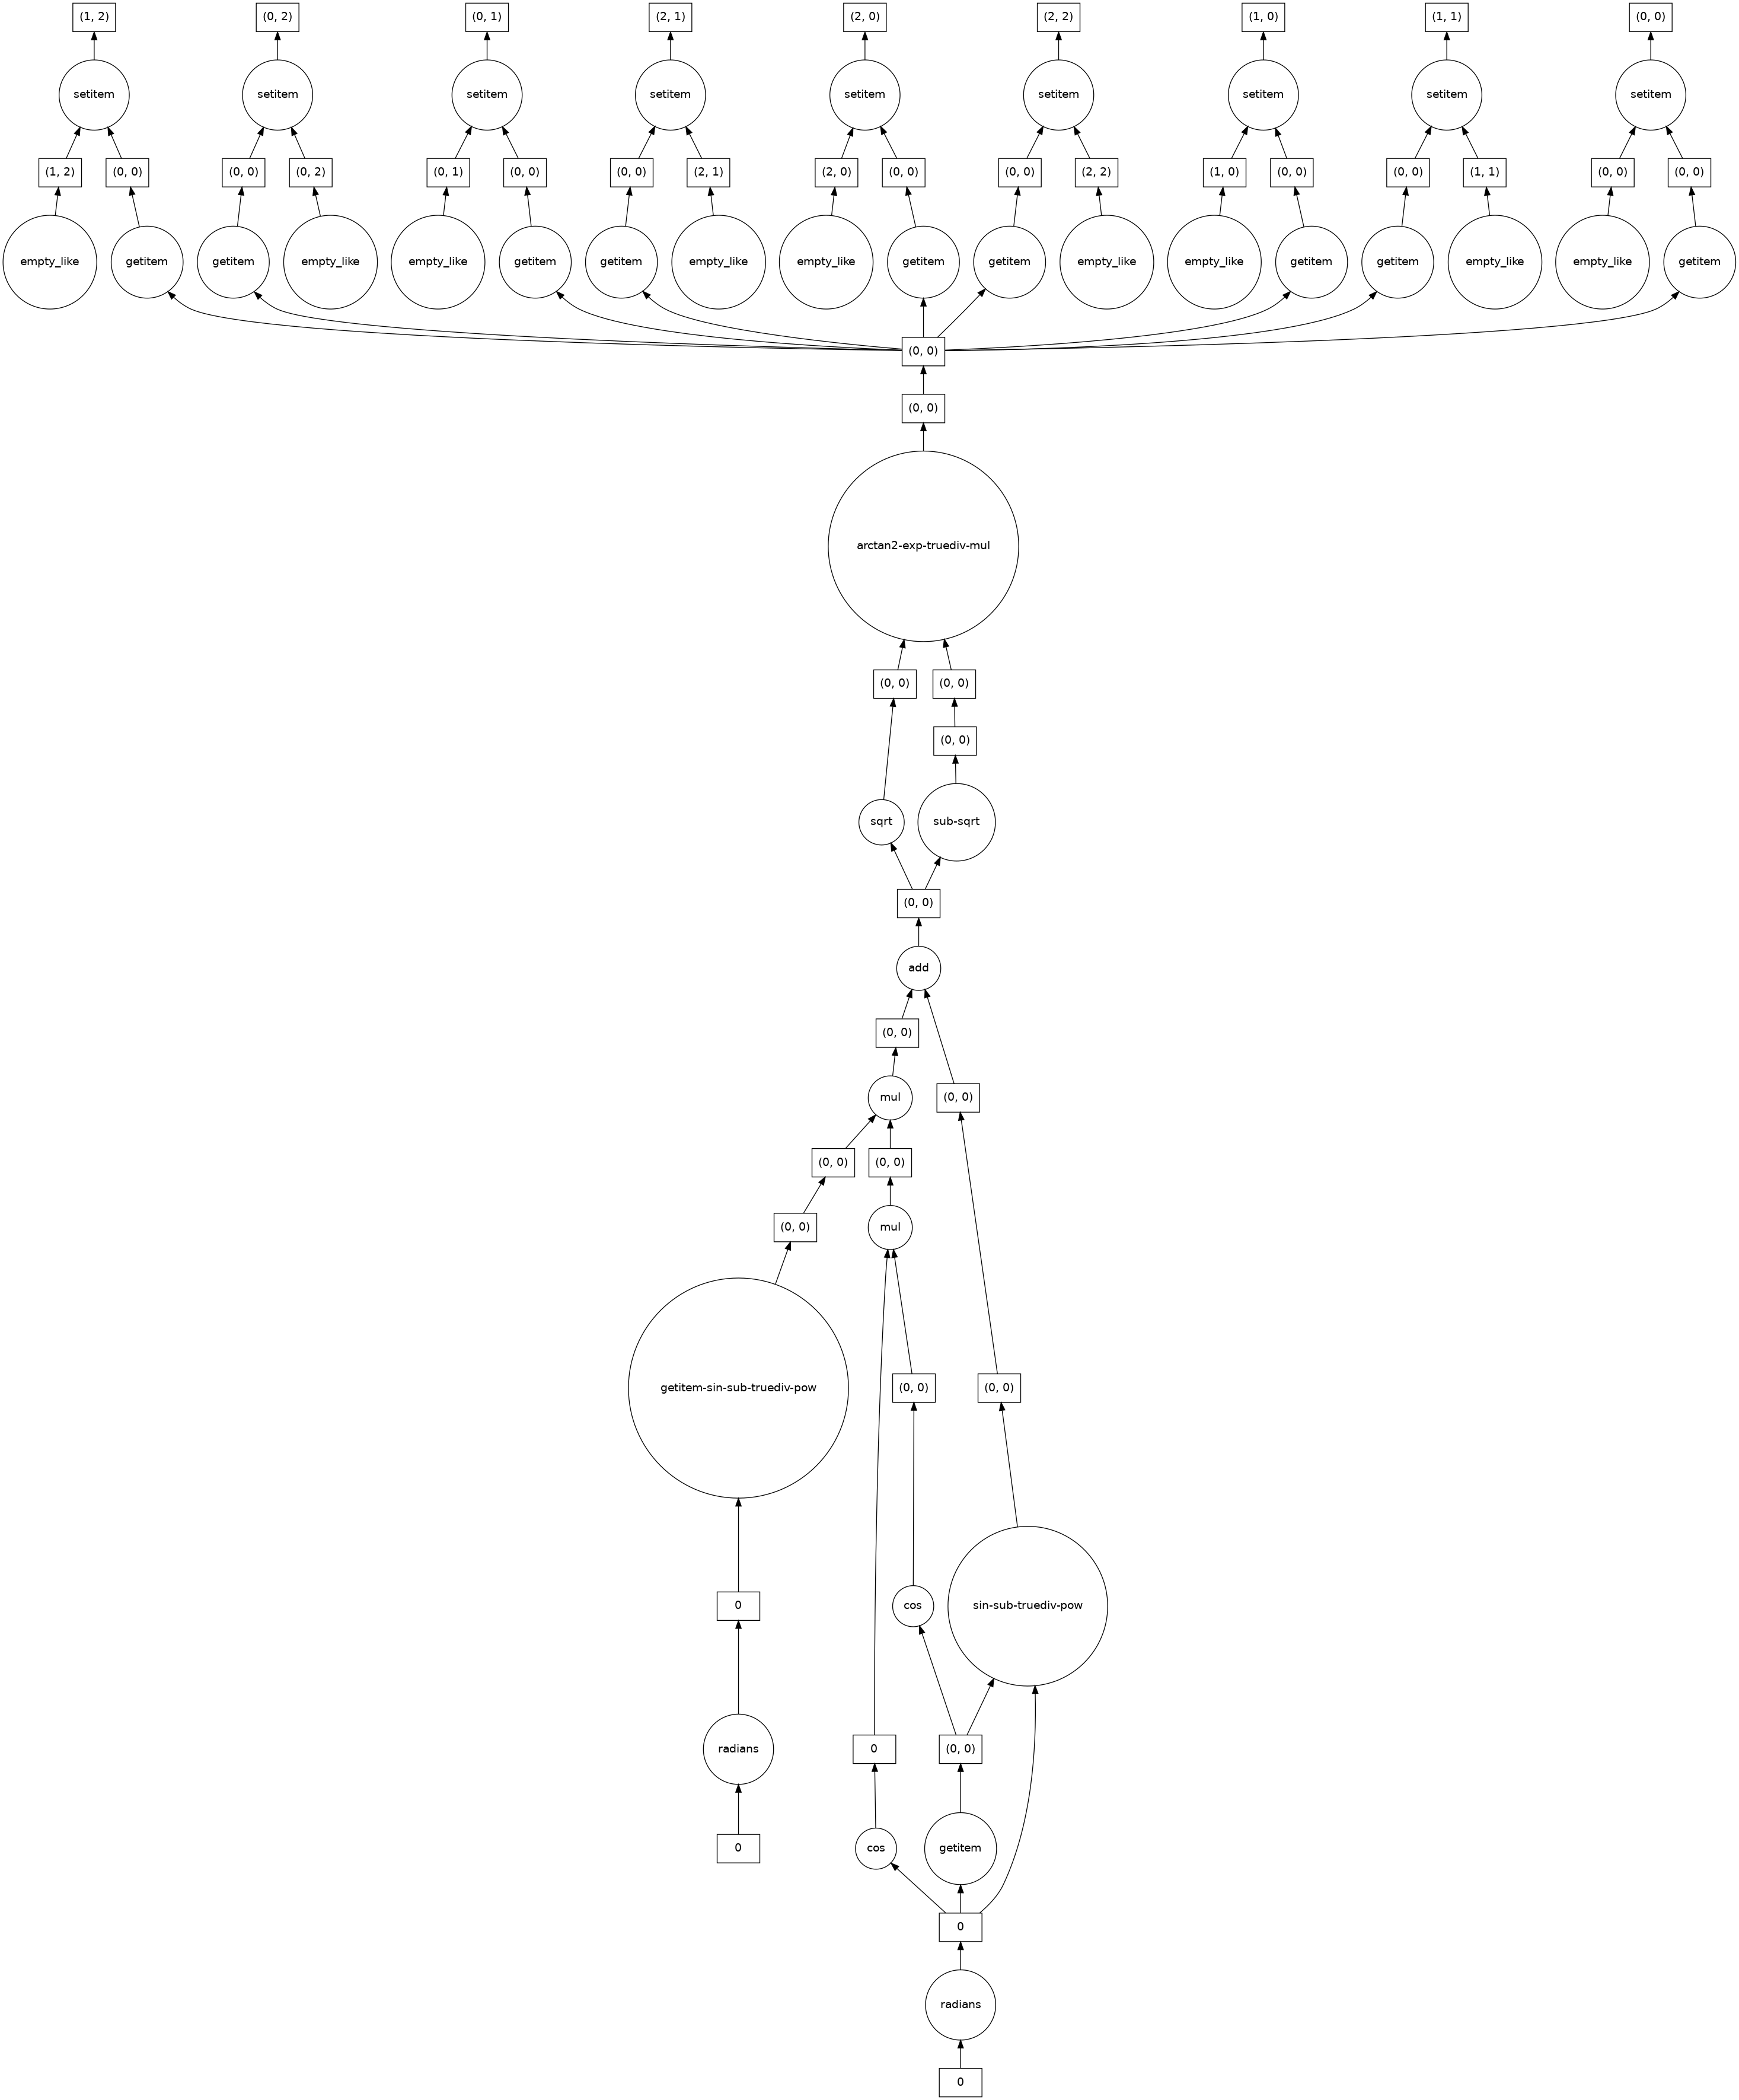

In [29]:
covv.visualize(optimize_graph = True)

In [22]:
latv

dask.array<array, shape=(11678,), dtype=float64, chunksize=(11678,), chunktype=numpy.ndarray>

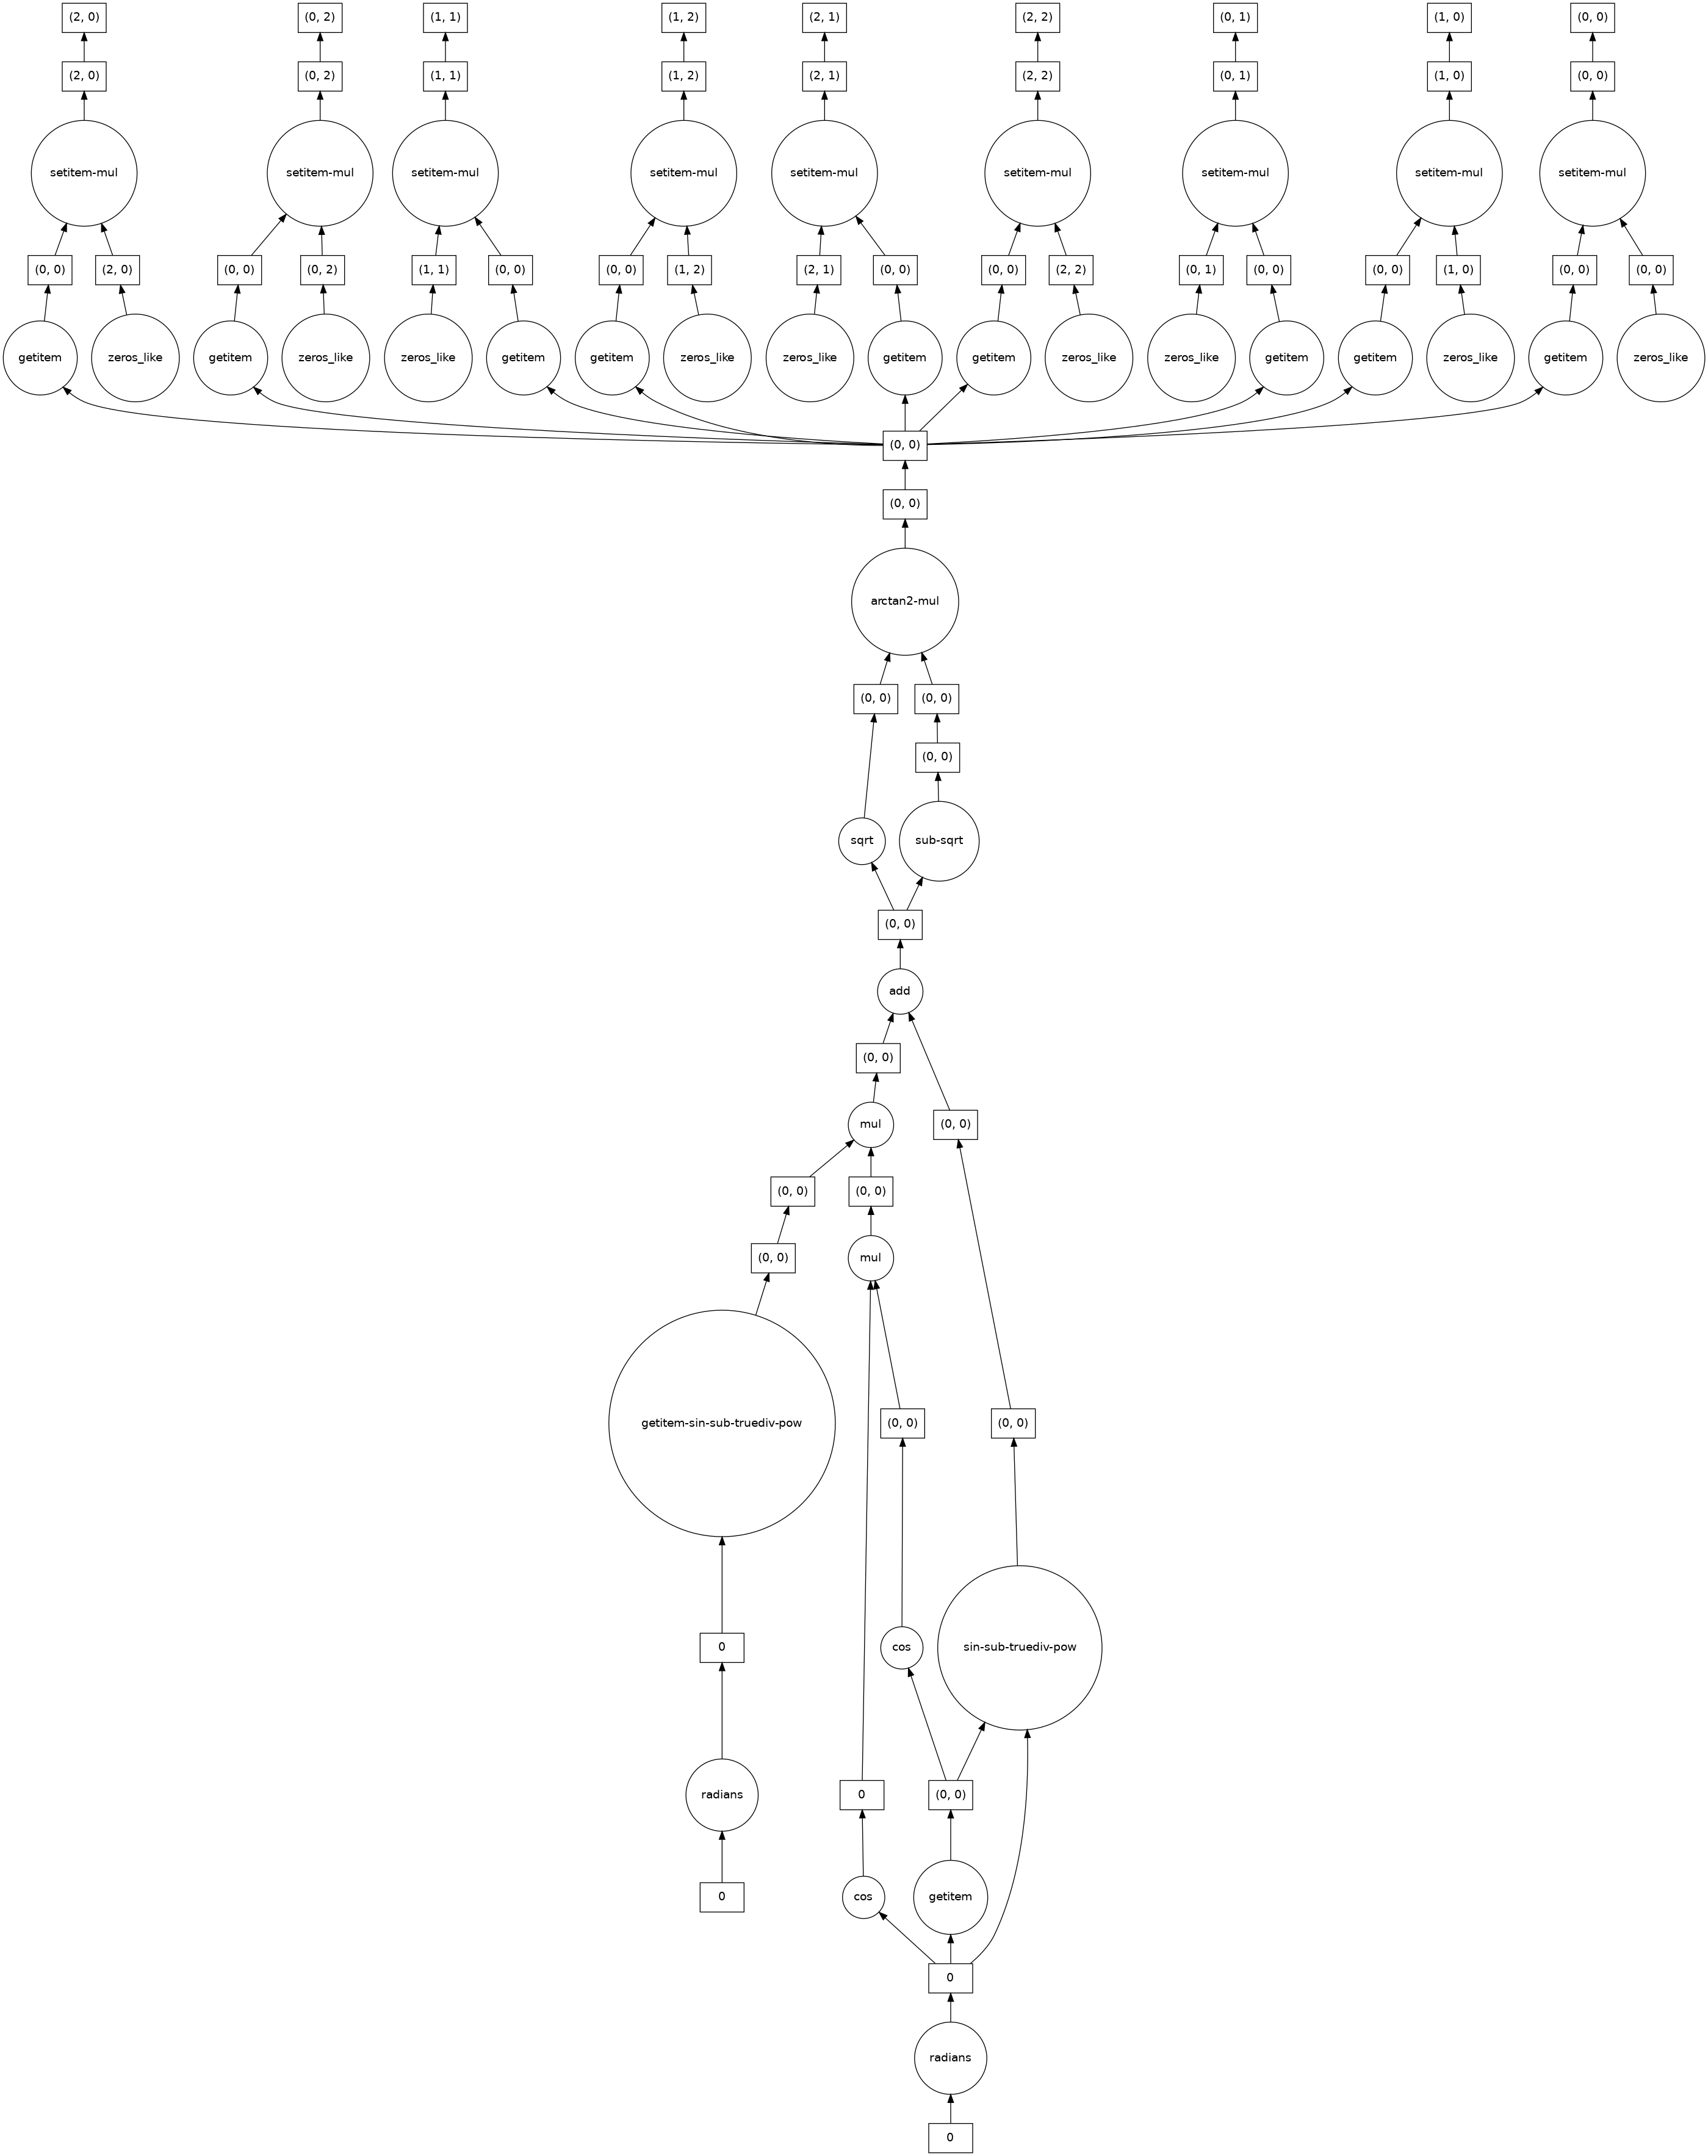

In [30]:
covv.visualize( optimize_graph=True)

# Compare to implementation where chunks given via latv, lonv and no initializing dists

In [27]:
latv2 = latgrid[lsm].flatten()
lonv2 = longrid[lsm].flatten() 

latv2 = da.from_array(latv2, chunks=4096)
lonv2 = da.from_array(lonv2, chunks=4096)
dists2 = haversine_distance(latv2, lonv2)
covv2 = sigma**2*da.exp(-1*dists2/l)

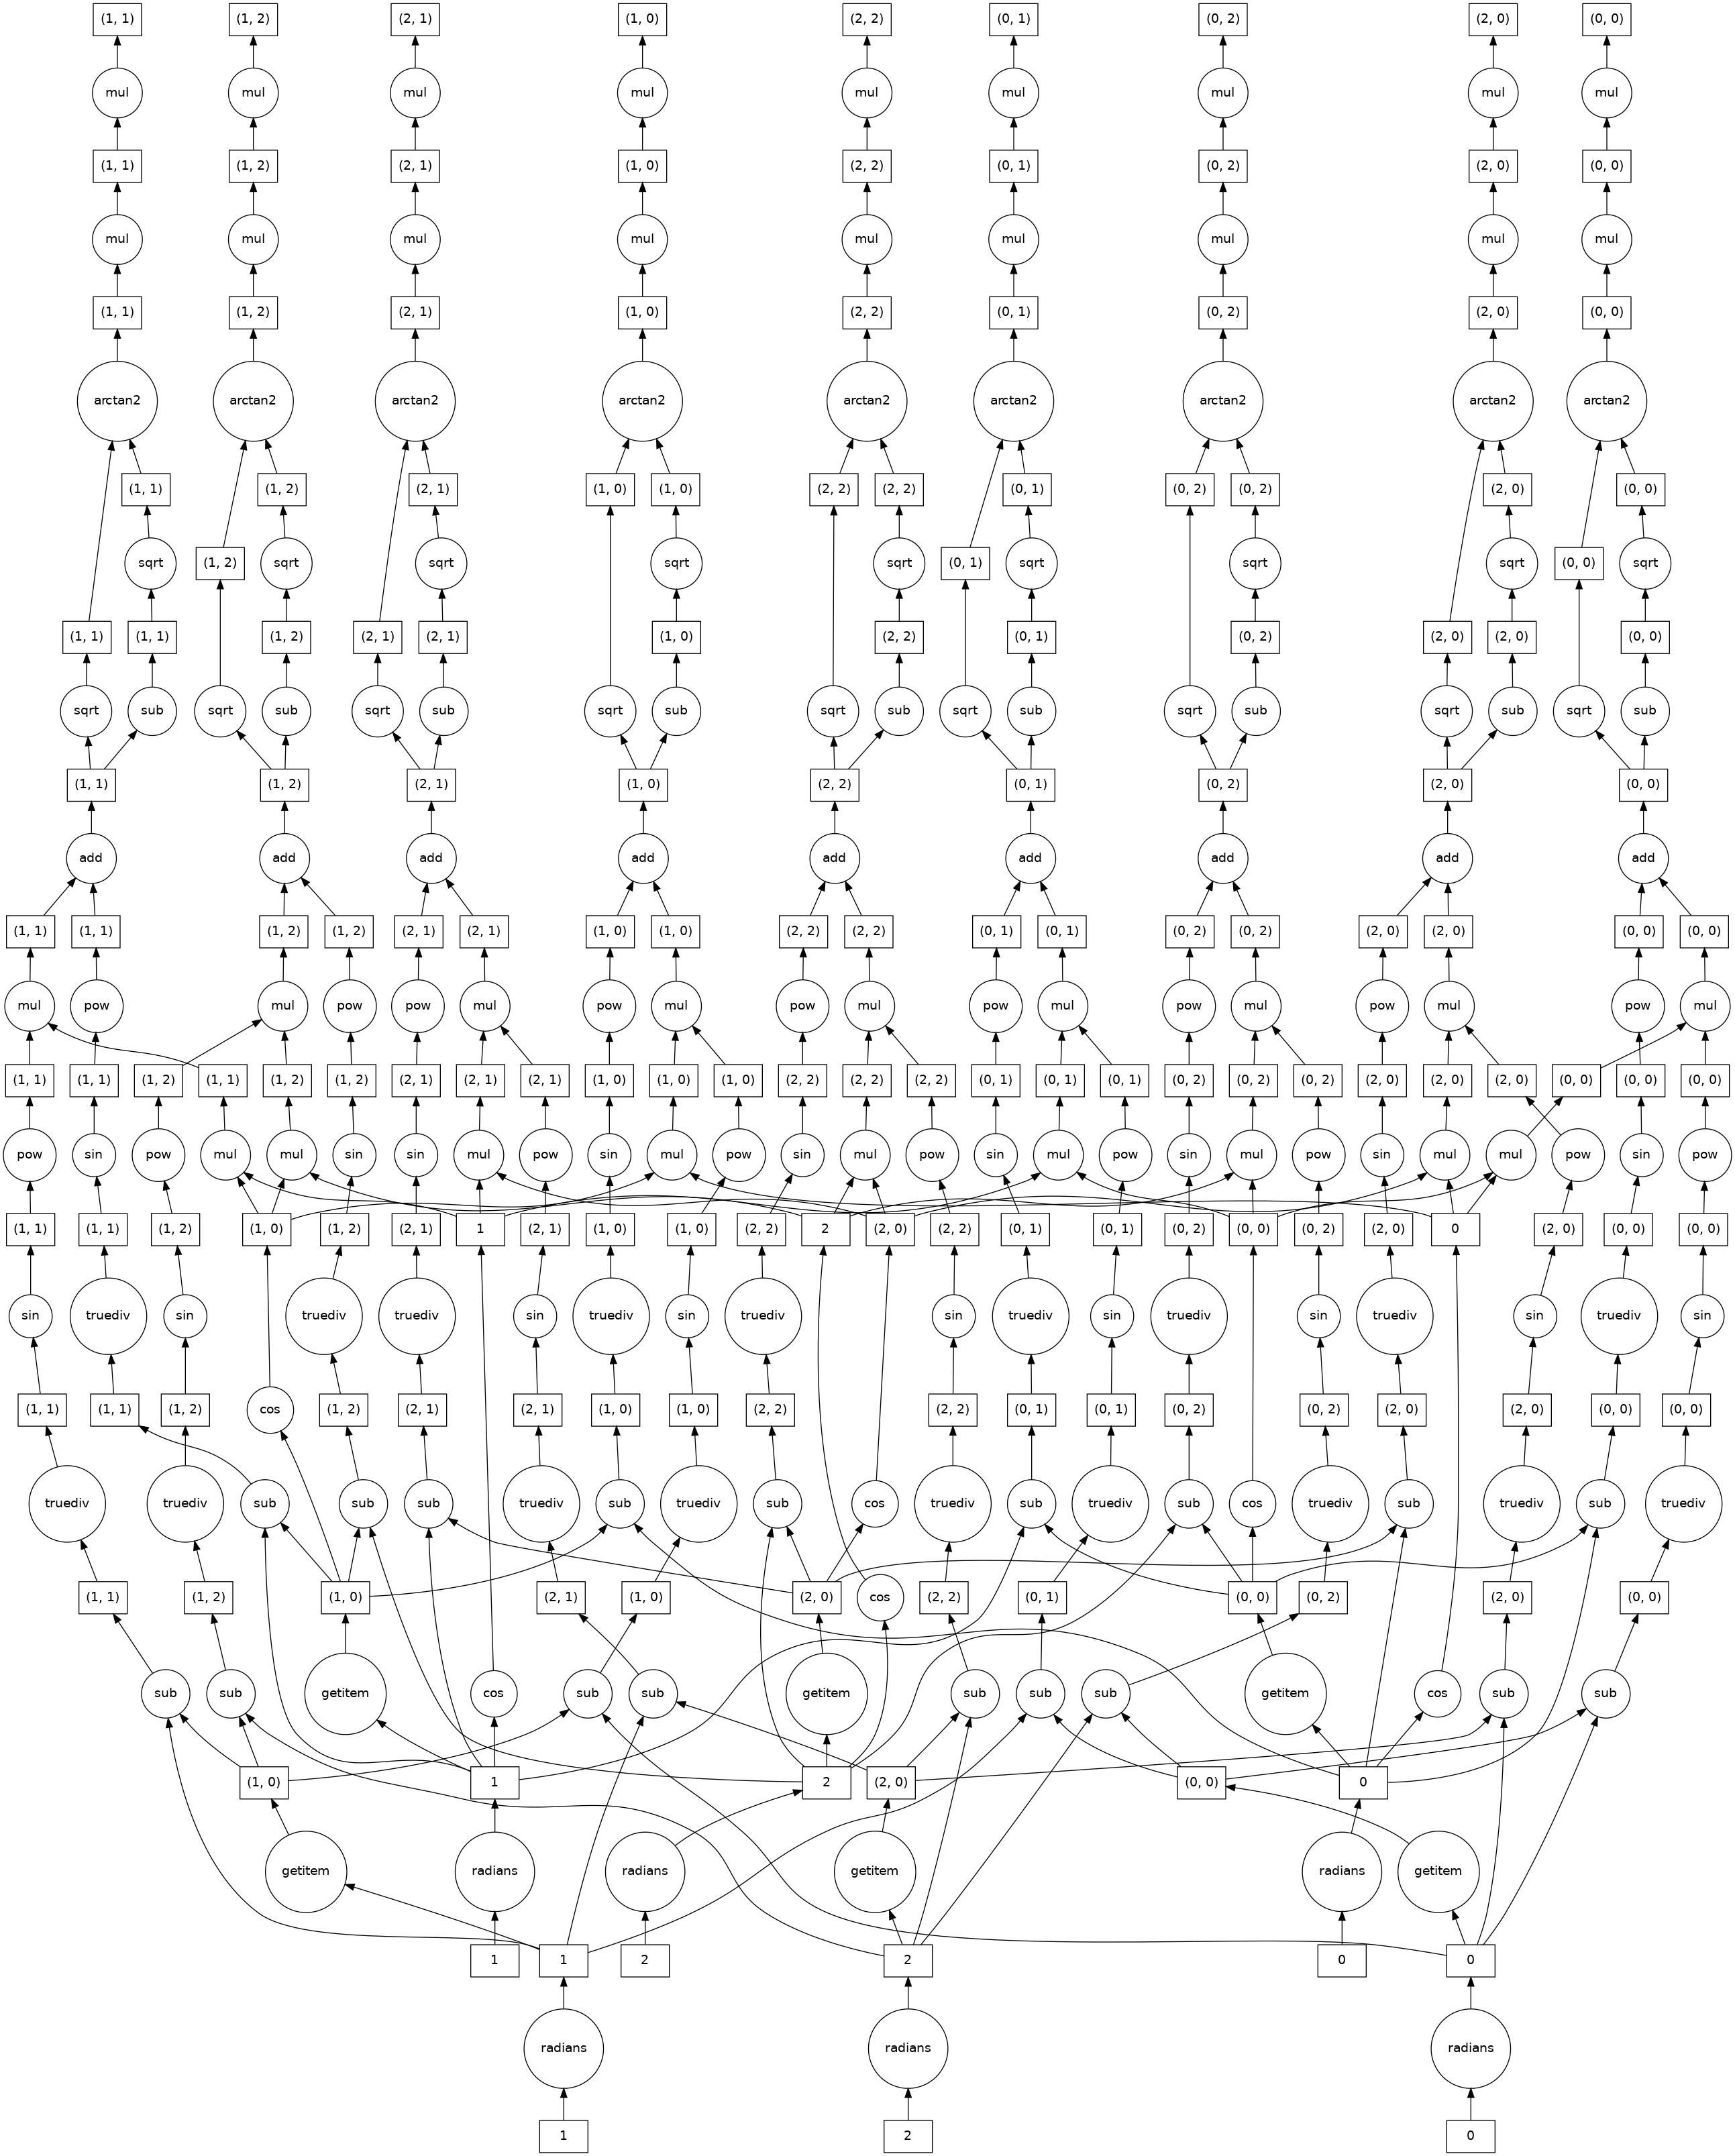

In [28]:
dists2.visualize()

In [29]:
dists2

dask.array<mul, shape=(11678, 11678), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [31]:
ds = create_dataset(covv, latv, lonv, v)
today = datetime.now()
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
fname = f'CO2_prior_cov_eur_{v}_{today.strftime("%d%m%Y")}.nc'
ds.to_netcdf(os.path.join(OUTPUT_PATH, fname))

Try the two for-loops version of making the cov matrix with dask
* i.e. version that Aki & Maria use

In [20]:
cov, lat, lon = compute_cov_separately(lsm, latgrid, longrid, sigmas, L, "land").compute()

In [1]:
client.shutdown()

NameError: name 'client' is not defined